**COVID-19 and health topics in European Parliament Debated (2020)** - Suchanya Baiyam - Business Data Science AAU

- Focus at how different groups in the European Parliament talked about COVID-19 and health issues in 2020.
- Using language model to identify health-related speeches and then analyzed how parties are connected through these topics by using a network


Scope: EU debate speech from 2020 because it represents the first full year in which COVID-19 emerged as a major political and public health crisis in Europe.


Assignment Pipeline:
Step01:
Step02:
Step03:
Step04:
Step05:

--Original dataset--
- EU Debates 2019 - 2023
- Dataset: https://huggingface.co/datasets/RJuro/eu_debates

**Stop0: Download libraries and dataset exploration**

What did I do:
- Load the libraries
- Import the dataset of EU debate
- Initial exploration to understand structure, key variables, and overall size
- Only focus on 2020 debate
- Basic data inspect
- Text preparation by building column 'analysis_text', using translated_text but if there's no data using text (original english text) instead
- Save in CSV file for LLM extraction

In [1]:
!pip install -U datasets pandas
from datasets import load_dataset
import pandas as pd
debates = load_dataset("RJuro/eu_debates", split="train")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
print(debates[0])

{'speaker_name': 'President', 'speaker_role': 'EUROPARL President', 'speaker_party': 'N/A', 'intervention_language': 'en', 'original_language': 'en', 'date': datetime.datetime(2009, 7, 14, 0, 0), 'year': '2009', 'debate_title': 'Opening of the sitting (first sitting of the newly elected Parliament) Video of the speechesPV', 'text': 'Ladies and gentlemen, under the terms of the Act concerning the election of the representatives of the European Parliament by direct universal suffrage, I declare the first sitting of the European Parliament following the elections open. (Applause) I would ask you to rise for the European anthem. Ladies and gentlemen, I warmly welcome you to the first sitting of the European Parliament following the elections and congratulate you all: the re-elected Members and the newly elected Members. A little under half of the 736 Members have been elected to the European Parliament for the first time. It is particularly heartening that 35% of the Members are women – a 

In [3]:
df = pd.DataFrame(debates)
df.head()

,speaker_name,speaker_role,speaker_party,intervention_language,original_language,date,year,debate_title,text,translated_text
0,President,EUROPARL President,N/A,en,en,2009-07-14,2009,Opening of the sitting (first sitting of the n...,"Ladies and gentlemen, under the terms of the A...",NaN
1,President,EUROPARL President,N/A,en,en,2009-07-14,2009,Election of the President of the European Parl...,"This morning, in accordance with the Rules of ...",NaN
2,Eva-Britt Svensson,MEP,GUE/NGL,en,sv,2009-07-14,2009,Election of the President of the European Parl...,"Mr President, ladies and gentlemen, I would l...",NaN
3,Jerzy Buzek,MEP,PPE,en,pl,2009-07-14,2009,Election of the President of the European Parl...,"Mr President, representatives of the Council ...",NaN
4,President,EUROPARL President,N/A,en,en,2009-07-14,2009,Election of the President of the European Parl...,I will now announce the result of the vote. Nu...,NaN


In [4]:
df_2020 = df[df["year"] == "2020"]
len(df_2020)

8790

In [5]:
df_2020["analysis_text"] = df_2020["translated_text"].fillna(df_2020["text"])

In [6]:
df_2020["analysis_text"].isna().sum()

np.int64(0)

In [7]:
#chat gpt suggested to see some text from dataset
for i in range(3):
    print("---- SPEECH", i, "----")
    print(df_2020.iloc[i]["analysis_text"][:500])

---- SPEECH 0 ----
and – Declaration relating to the session of the European Parliament interrupted on Thursday, 19 December 2019.
---- SPEECH 1 ----
On behalf of the Parliament and personally I wish to express my most sincere condolences to the families and friends of the victims of the tragic Ukrainian aircraft crash, which was crashed shortly after landing from the Iranian capital Tehran on Wednesday, killing all the 176 passengers and crew members on board. We trust that a thorough, accurate and transparent investigation ensures justice to the victims. I invite you to observe a minute of silence in their memory. (The Parliament, standing,
---- SPEECH 2 ----
 January 13, 1991 was essentially the last of the Battle of the Second World War. It was delayed because it had been almost fifty years since the Ribentropo-Molotov Pact, but won.  Thank you, Mr. President, that you entered the unforgettable, which many of my colleagues have entered today. Today, January 13 is not just the day o

In [8]:
df_2020["speaker_party"].value_counts()

speaker_party
N/A           1778
PPE           1660
S&D           1564
ECR            828
ALDE           823
ID             661
Greens/EFA     604
GUE/NGL        526
NI             346
Name: count, dtype: int64

In [9]:
df_2020 = df_2020[df_2020["speaker_party"] != "N/A"]

In [10]:
len(df_2020)
df_2020["speaker_party"].value_counts()

speaker_party
PPE           1660
S&D           1564
ECR            828
ALDE           823
ID             661
Greens/EFA     604
GUE/NGL        526
NI             346
Name: count, dtype: int64

In [18]:
df_2020.to_csv("eu_debates_2020_clean.csv", index=False)

In [19]:
from google.colab import files
files.download("eu_debates_2020_clean.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Step1: Rulebased + Keyword Exploration**

To see breifly if the dataset in 2020 have health contect and design prompt of LLM-based extraction

What did i do:
- Give the keyword list that related to health and COVID-19
- Using string matching
- See the speech that have mentioned keywords
- See the example of the speeches

What I noticed:
- There's still speech that did not mention or refer about health or COVID-19 (like directly mentioned about environment)

In [11]:
health_keywords = [
    "covid", "covid-19", "coronavirus", "corona",
    "pandemic",
    "health", "public health",
    "vaccine", "vaccination",
    "healthcare", "hospital"
]

In [12]:
def mentions_health_kw(text, keywords):
    text = text.lower()
    return any(k in text for k in keywords)

In [13]:
df_2020["mentions_health_kw"] = df_2020["analysis_text"].apply(
    lambda x: mentions_health_kw(x, health_keywords)
)

In [14]:
df_2020["mentions_health_kw"].value_counts(normalize=True)

mentions_health_kw
False    0.691101
True     0.308899
Name: proportion, dtype: float64

In [15]:
party_health_rate = (
    df_2020
    .groupby("speaker_party")["mentions_health_kw"]
    .mean()
    .sort_values(ascending=False)
)

party_health_rate

speaker_party
S&D           0.363811
PPE           0.324699
ECR           0.314010
GUE/NGL       0.281369
NI            0.274566
ALDE          0.270960
ID            0.270802
Greens/EFA    0.253311
Name: mentions_health_kw, dtype: float64

In [16]:
df_2020[df_2020["mentions_health_kw"] == True][
    ["speaker_party", "analysis_text"]
].head(3)

,speaker_party,analysis_text
59904,PPE,"“Mr. President, Australia offers us a real pi..."
60013,ALDE,The Czech Republic has the second largest ave...
60017,GUE/NGL,"In the European Union, women work for two mon..."


In [17]:
sample = df_2020[df_2020["mentions_health_kw"] == True].sample(3, random_state=42)

for idx, row in sample.iterrows():
    print("\nParty:", row["speaker_party"])
    print("-" * 60)
    print(row["analysis_text"][:1000])


Party: S&D
------------------------------------------------------------
on behalf of the S&D Group. – Madam President, arrests of presidential candidates and peaceful protesters, and the violent crackdown on the Opposition and civil society is a picture of Belarus today. We condemn it in the strongest possible terms. We cannot tire of repeating that the violence and repression against the people of Belarus must stop and new elections must be held. Cooperation with the Belarusian authorities is no longer possible as long as the regime continues the brutal repression against the people and does not release all recent detainees and political prisoners. This is why the European Union must move from critical engagement to critical reassessment. To start with, European Union financial assistance must solely benefit civil society. We in the S&D Group also want to support the victims of repression, offer help to deal with the socio-economic consequences of the Covid—19 pandemic, and also cont

**Step2: LLM for structured extraction**
- in saparate csv file due to LLM settings

What did I do:
- Using LLM (Ollama gemma3:4b) to extract the health related topics
- Set the sample size of 1000 speeches for feasibility
- Expected output as JSON structure then save as CSV

Decided Prompt:




```
You are an expert in political science and natural language processing. Your task is to analyze the following speech text from a European Parliament debate and extract,
Task: Decide wether the sceeph discusses
- COVID-19
- public health issues
- vaccination
- healthcare systems
- hospitals
- public health emergency
- dicease control
- pandemic
- health policies

Do not include other topics e.g. environment or climate change unless they are explicitly linked to COVID-19 or public health.

Return ONLY valid JSON in the following format:
{{
  "health_mentioned": true or false,
  "health_topics": [list of short topic phrase]
}}
Speech:
\"\"\"{text[:3000]}\"\"\"
```





**Step3: Descriptive analysis**

To analyse the result from LLM-based extraction
What did I do:
- See the proportion of speeches which mentioned health
- The most mentioned health topics
- Difference between paries
- Visualization (bar chart and heatmap)

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sns
import ast

In [79]:
llm_df = pd.read_csv("eu_debates_2020_llm_health_sample1000.csv")

In [80]:
llm_df["health_mentioned"] = llm_df["health_mentioned"].fillna(False)

In [81]:
llm_df["health_mentioned"].value_counts(normalize=True)

health_mentioned
False    0.631
True     0.369
Name: proportion, dtype: float64

In [82]:
llm_df.groupby("speaker_party")["health_mentioned"].mean().sort_values(ascending=False)

speaker_party
S&D           0.451613
PPE           0.394068
ALDE          0.382609
Greens/EFA     0.37234
NI            0.347826
ECR           0.309091
GUE/NGL       0.275862
ID            0.263158
Name: health_mentioned, dtype: object

In [83]:
topics = (
    llm_df[llm_df["health_mentioned"]]
    .explode("health_topics")["health_topics"]
)

Counter(topics).most_common(10)

[("['COVID-19', 'public health issues', 'vaccination', 'healthcare systems', 'hospitals', 'public health emergency', 'disease control', 'pandemic', 'health policies']",
  29),
 ("['COVID-19', 'public health issues', 'healthcare systems', 'disease control', 'pandemic']",
  13),
 ("['COVID-19', 'public health issues', 'vaccination', 'healthcare systems', 'disease control', 'pandemic', 'health policies']",
  6),
 ("['COVID-19', 'public health issues', 'vaccination', 'healthcare systems', 'public health emergency', 'disease control', 'pandemic', 'health policies']",
  6),
 ("['COVID-19', 'public health issues', 'vaccination', 'healthcare systems', 'hospitals', 'public health emergency', 'disease control', 'pandemic']",
  6),
 ("['COVID-19', 'public health issues', 'vaccination', 'healthcare systems', 'public health emergency', 'disease control', 'pandemic']",
  6),
 ("['COVID-19', 'public health issues', 'vaccination', 'healthcare systems', 'disease control', 'pandemic']",
  4),
 ("['COVID

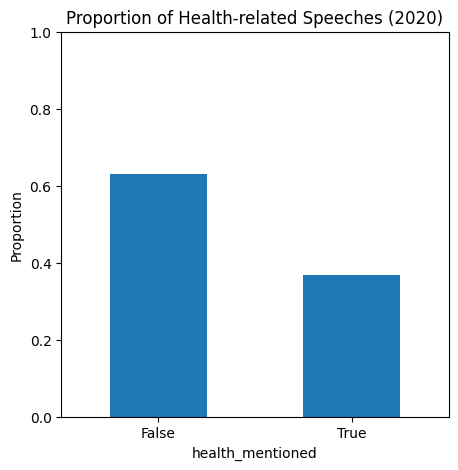

In [84]:
counts = llm_df["health_mentioned"].value_counts(normalize=True)

plt.figure(figsize=(5, 5))
counts.plot(kind="bar")
plt.title("Proportion of Health-related Speeches (2020)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()


- Proportion of Health-related Speeches (2020)

This graph shows the proportion id speeches mentioning health issues in 2020. Approximately 37% mentioned health or COVID-19, while the majority continued to focus on other issues. This can be interpreted that health is a significant issue, but not the only topic discussed in EU Parliament.


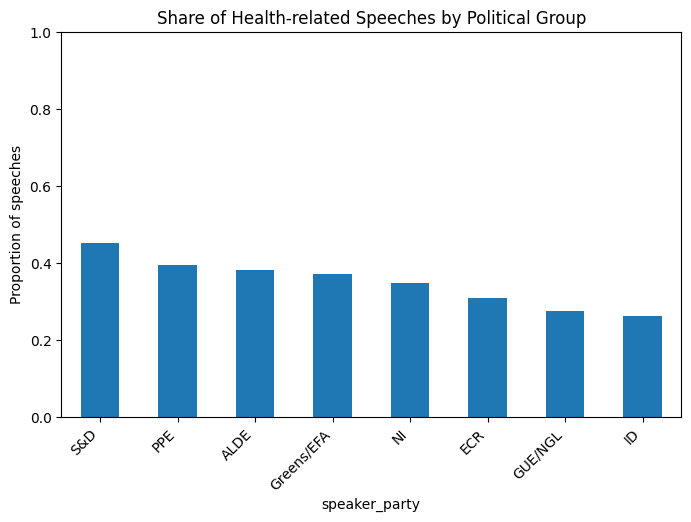

In [85]:
party_rate = (
    llm_df
    .groupby("speaker_party")["health_mentioned"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
party_rate.plot(kind="bar")
plt.title("Share of Health-related Speeches by Political Group")
plt.ylabel("Proportion of speeches")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.show()


- Share of Health-related Speeches by Political Group (2020)

This graph compares the proportion of health related speeches among different political parties. S&D and PPE had higher proportion reflecting the major rol in driving health discussions during the pandemic.

In [88]:
#suggested by chatGPT to solve health topic or transform string into list
llm_df["health_topics"] = llm_df["health_topics"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

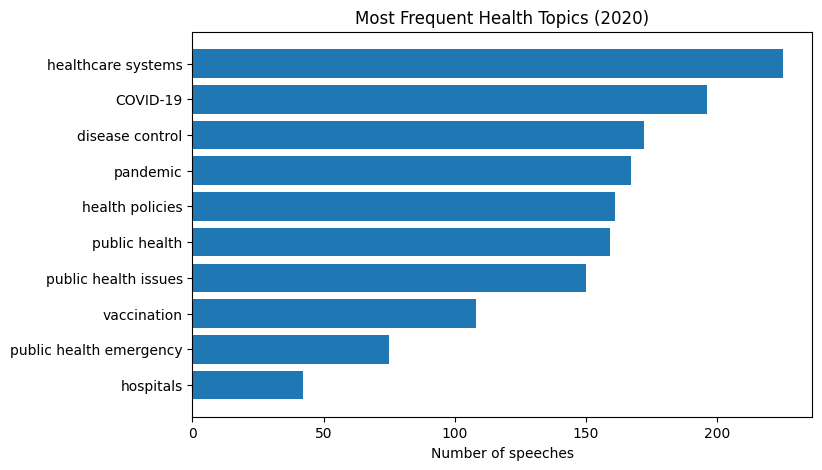

In [89]:
#suggested by chat gpt
topics = (
    llm_df[llm_df["health_mentioned"]]
    .explode("health_topics")["health_topics"]
)

topic_counts = Counter(topics).most_common(10)

labels, values = zip(*topic_counts)

plt.figure(figsize=(8, 5))
plt.barh(labels[::-1], values[::-1])
plt.title("Most Frequent Health Topics (2020)")
plt.xlabel("Number of speeches")
plt.show()


- Most Frequent Health Topics (2020)

We found that healthcare systems was the most frequently discussed topic. This shows that the discussions were not solely focused on the dicease.

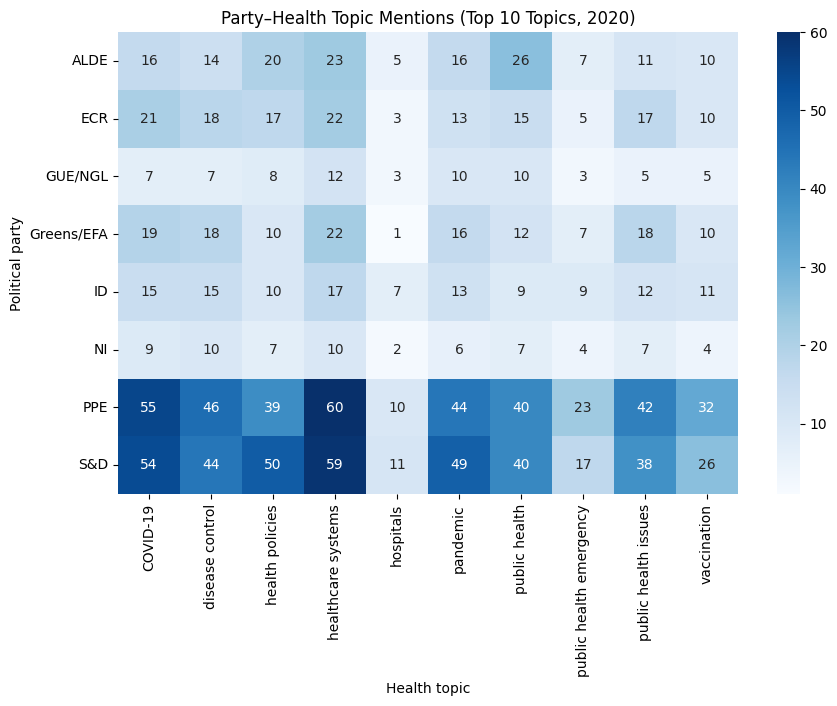

In [90]:
#suggested by chat gpt to solve health topics

#step1finding top15
top_topics = (
    llm_df[llm_df["health_mentioned"]]
    .explode("health_topics")["health_topics"]
    .value_counts()
    .head(10)
    .index
)

#step2filter dataframe before ploting
party_topic_top = (
    llm_df[llm_df["health_mentioned"]]
    .explode("health_topics")
    .query("health_topics in @top_topics")
    .groupby(["speaker_party", "health_topics"])
    .size()
    .reset_index(name="count")
)

pivot_top = party_topic_top.pivot(
    index="speaker_party",
    columns="health_topics",
    values="count"
).fillna(0)

#step3plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_top, cmap="Blues", annot=True, fmt=".0f")
plt.title("Party–Health Topic Mentions (Top 10 Topics, 2020)")
plt.xlabel("Health topic")
plt.ylabel("Political party")
plt.show()

- Party-Health Topic Mentions (Top 10 Topics, 2020)

This heatmap shows the relationship between parties and health topics. It reveals that PPE and S&D had higher mentions of almost all health topics than others, particularly healthcare systems, COVID-19, and the Pandemic. Reflecting the leading roles of these two groups in EU debates 2020.

**Step4: Knowledge Graph**

The knowledge graph provides a visual overview of how different parties are connected to health topics during 2020 (considered COVID-19 period). It hilights which parties are central in debates and show the overall structure of health-related discourse in EU Parliament in 2020.

In [92]:
#chat gpt suggested to set up the edge list (knowledge graph format)
kg_edges = party_topic_top.rename(
    columns={
        "speaker_party": "source",
        "health_topics": "target",
        "count": "weight"
    }
)

kg_edges.head()

,source,target,weight
0,ALDE,COVID-19,16
1,ALDE,disease control,14
2,ALDE,health policies,20
3,ALDE,healthcare systems,23
4,ALDE,hospitals,5


In [97]:
import networkx as nx
G = nx.Graph()

for _, row in kg_edges.iterrows():
  G.add_node(row["source"], node_type="party")
  G.add_node(row["target"], node_type="health_topic")

  G.add_edge(
      row["source"],
      row["target"],
      relation="mentions",
      weight=row["weight"]
  )

In [98]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 18
Edges: 80


In [99]:
list(G.edges(data=True))[:5]

[('ALDE', 'COVID-19', {'relation': 'mentions', 'weight': 16}),
 ('ALDE', 'disease control', {'relation': 'mentions', 'weight': 14}),
 ('ALDE', 'health policies', {'relation': 'mentions', 'weight': 20}),
 ('ALDE', 'healthcare systems', {'relation': 'mentions', 'weight': 23}),
 ('ALDE', 'hospitals', {'relation': 'mentions', 'weight': 5})]

In [100]:
print("Nodes:", G.nodes(data=True))
print("Edges:", G.edges(data=True))

Nodes: [('ALDE', {'node_type': 'party'}), ('COVID-19', {'node_type': 'health_topic'}), ('disease control', {'node_type': 'health_topic'}), ('health policies', {'node_type': 'health_topic'}), ('healthcare systems', {'node_type': 'health_topic'}), ('hospitals', {'node_type': 'health_topic'}), ('pandemic', {'node_type': 'health_topic'}), ('public health', {'node_type': 'health_topic'}), ('public health emergency', {'node_type': 'health_topic'}), ('public health issues', {'node_type': 'health_topic'}), ('vaccination', {'node_type': 'health_topic'}), ('ECR', {'node_type': 'party'}), ('GUE/NGL', {'node_type': 'party'}), ('Greens/EFA', {'node_type': 'party'}), ('ID', {'node_type': 'party'}), ('NI', {'node_type': 'party'}), ('PPE', {'node_type': 'party'}), ('S&D', {'node_type': 'party'})]
Edges: [('ALDE', 'COVID-19', {'relation': 'mentions', 'weight': 16}), ('ALDE', 'disease control', {'relation': 'mentions', 'weight': 14}), ('ALDE', 'health policies', {'relation': 'mentions', 'weight': 20}), 

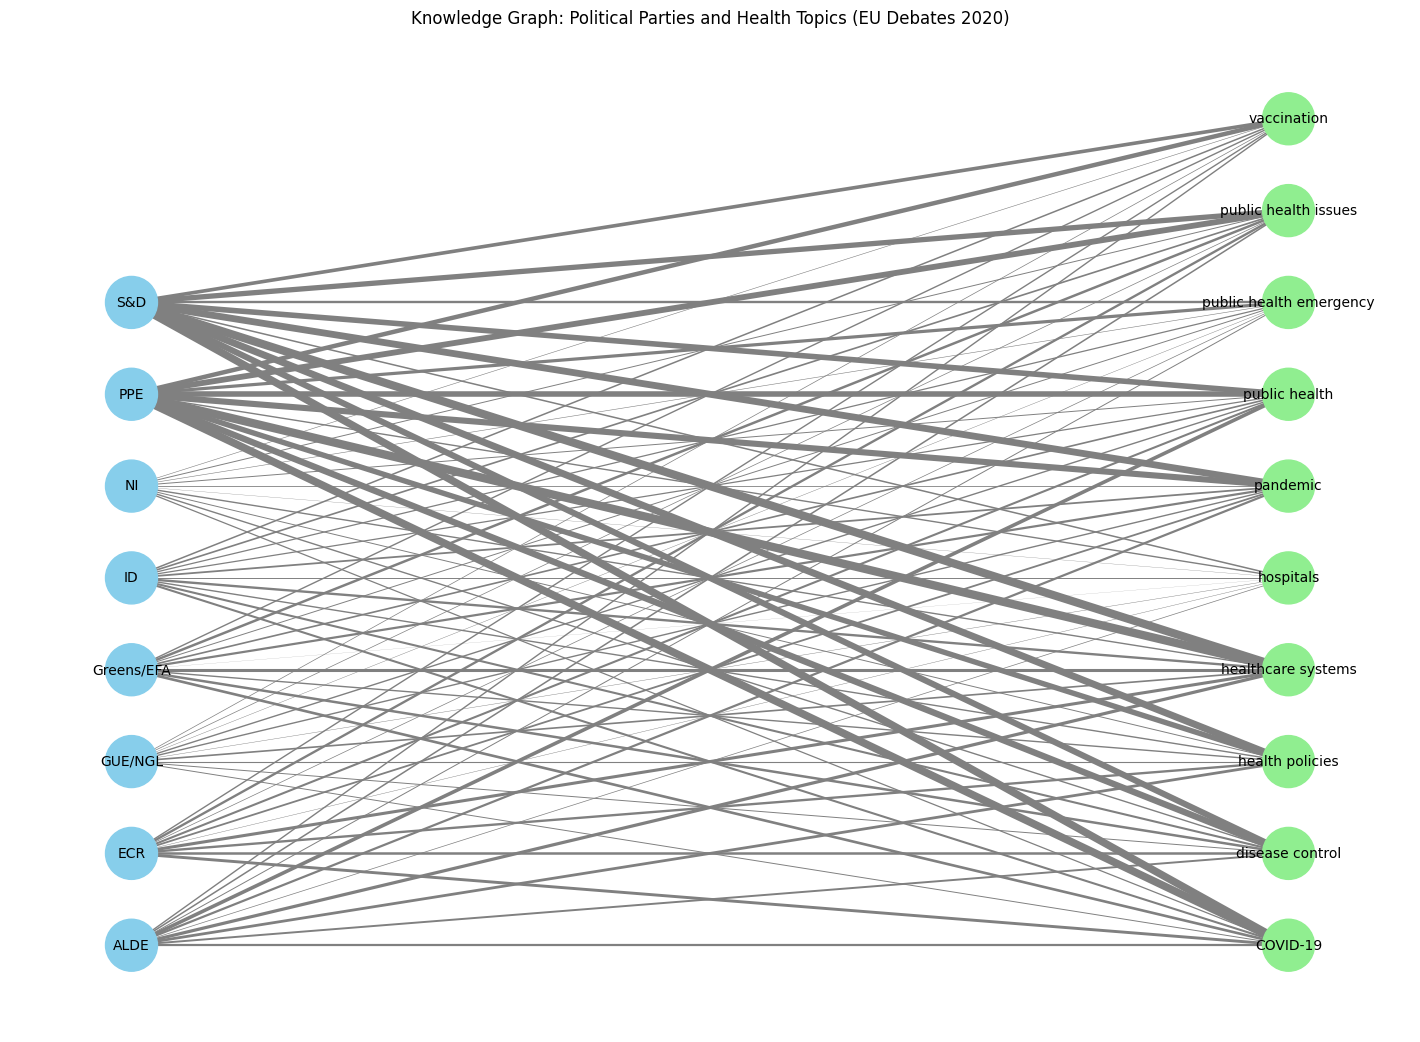

In [106]:
#graph layout suggested by chat gpt
#weight from edge
weights = [G[u][v]["weight"] for u, v in G.edges()]

plt.figure(figsize=(14, 10))

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1400,
    node_color=[
        "skyblue" if G.nodes[n]["node_type"] == "party" else "lightgreen"
        for n in G.nodes()
    ],
    width=[w / 10 for w in weights],  #scale of boldness
    edge_color="gray",
    font_size=10
)

plt.title("Knowledge Graph: Political Parties and Health Topics (EU Debates 2020)")
plt.axis("off")
plt.show()


- Knowledge Graph structure: bipartite graph consisting of parties and health topics as nodes. An edge represents that party mentioned a specific health topic in the denates.
- The thickness of the edges represents the frequency of mentions, Thicker edges indicate that a party discussed a health topic more frequently during debates in 2020.

From this Knowledge Graph, PPE and S&D show how strong connections to many health topics, indicating broad engagement in health-related issues.

Healthcare system and COVID-19 are connected to most parties, indicating that these topic were widely discussed.

Smaller party show fewer and thinner connection, indicating more limited participation in health related debates.



**Step5: Network Analysis**

The same bipartite graph is used both as KG and as the basic for network analysis.
- Type of Network: Weighted Bipartite Network
- Nodes: Parties and Health Topics
- Edges: Mention to health topics

Graph structure: this network is not about party or politic allies, but showing the agenda overlap between parties and health issues in 2020.

*Degree Centrality*

Which party mentioned about health in diverse aspect?
- The highest degree means their debates connected to many health topics. It can be interpreted that they cover a wide range of health agendas.
But from the exploration, we can see that there are equal degree centrality across parties. It can indicate that most parties engaged with a similar range of topics related to health issue during COVID-19 pandemic, reflecting the major public health concerns in 2020.

In [107]:
#Degree Centality

deg = nx.degree_centrality(G)
deg_df = pd.DataFrame(list(deg.items()), columns=["node", "degree_centrality"])
deg_df.sort_values("degree_centrality", ascending=False).head(10)

,node,degree_centrality
0,ALDE,0.588235
14,ID,0.588235
12,GUE/NGL,0.588235
17,S&D,0.588235
15,NI,0.588235
16,PPE,0.588235
11,ECR,0.588235
13,Greens/EFA,0.588235
1,COVID-19,0.470588
2,disease control,0.470588


*Weighted Degree Centrality*

We can see that PPE and S&D has higest weighted degree centraility, meaning that they mentioned topics related to health more frequenrlt than other parties. This indicates that both of parties dominate the health related discourse in EU debated during 2020.


In [108]:
weighted_degree = dict(G.degree(weight="weight"))
wd_df = (
    pd.DataFrame(weighted_degree.items(), columns=["node", "weighted_degree"])
    .sort_values("weighted_degree", ascending=False)
)
wd_df

,node,weighted_degree
16,PPE,391
17,S&D,388
4,healthcare systems,225
1,COVID-19,196
2,disease control,172
6,pandemic,167
3,health policies,161
7,public health,159
9,public health issues,150
0,ALDE,148


*Topic Centrality*

The most mentioned health topic is healthcare systems, even surpassing direct mentions of COVID-19. This suggest that during the pandemic, EU parties focused more on the strength and functioning of healthcare systems rather than on the virus itself. Healthcare system appeared to be the central concern in discussion related to the pandemic.

In [109]:
#weighted degree for all nodes
weighted_degree = dict(G.degree(weight="weight"))

#health topics
topic_centrality = (
    pd.DataFrame(weighted_degree.items(), columns=["node", "weighted_degree"])
    .merge(
        pd.DataFrame.from_dict(
            nx.get_node_attributes(G, "node_type"),
            orient="index",
            columns=["node_type"]
        ),
        left_on="node",
        right_index=True
    )
    .query("node_type == 'health_topic'")
    .sort_values("weighted_degree", ascending=False)
)

topic_centrality


,node,weighted_degree,node_type
4,healthcare systems,225,health_topic
1,COVID-19,196,health_topic
2,disease control,172,health_topic
6,pandemic,167,health_topic
3,health policies,161,health_topic
7,public health,159,health_topic
9,public health issues,150,health_topic
10,vaccination,108,health_topic
8,public health emergency,75,health_topic
5,hospitals,42,health_topic


**Conclusion**

This assignment used NLP and network analysis to study health topics discussion in EU debates during 2020. Using LLM-based extraction approach speeches mentioning COVID-19 and public health topics were identified and structured into analyable data. Descriptive analysis shoed that healthcare systems and COVIS-19 were the most frequently discuss topic.

The KG and network analysis further revealed that PPE and S&D played central role in health-related discourse, while healcare systems emerged as the most influence topic.

Overall, this approach shows how combining text analysis and network method can provide meaningful insights into political discourse during majpr public health crisis.

**LLM-based limitations**
1. The result depends a lot on prompt design, and different prompts or models may produce different classifications.
2. The LLM still unable to perform perfectly on indirectly mentioned classification.
3. The LLM-based label has no ground truth, it is generalized and should be seen as the approximation, as no manual annotion was used for validation.

**Open Question**
- To what extent do LLM-based topic classifications align with human expert annotations in political debate analysis?